In [29]:
import numpy as np
import pandas as pd
from IPython import display
from collections import Counter
from matplotlib import pyplot as plt
from mxnet import autograd, nd, init as ginit
from mxnet.gluon import nn, loss as gloss, data as gdata, Trainer as gTrainer

In [2]:
# 读取数据 using pandas
train_data = pd.read_csv("./DataResources/PA_1/train.csv")
test_data = pd.read_csv("./DataResources/PA_1/test.csv")

### 预处理数据
1. 了解各column的意义和值的分布: 所有列都会参与训练
2. dtype为object的列 被拆分成几列
3. dtype不为object将被归一化, 并且训练集和测试集一起归一化
4. 填补非object列的缺失值

In [3]:
def explore_dtype():
    for dtype in ['object', 'int', 'float']:
        single_type = train_data.select_dtypes(include=[dtype])
        print(dtype, ": ", single_type.shape[1], ": ", ",".join(single_type.columns))
explore_dtype()

object :  43 :  MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
int :  35 :  Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
float :  3 :  LotFrontage,MasVnrArea,GarageYrBlt


In [4]:
def preprocess(train_data, test_data):
    # 合并
    # exclude label and id
    # 使用iloc小心, 维度之间用comma隔开, 而不是 ][
    all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]), sort=False)
    numerical_index = all_features.dtypes[all_features.dtypes != 'object'].index
    all_features[numerical_index] = all_features[numerical_index].apply(lambda x: (x - x.mean()) / x.std())
    all_features[numerical_index] = all_features[numerical_index].fillna(0)  # 如果归一化在fillna之后会如何
    flat_features = pd.get_dummies(all_features, dummy_na=True)  # nan 也作为一类
    return flat_features


def simply_data(train_data, test_data):
    all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]), sort=False)
    need_indices = ['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'YearBuilt']
    sub_features = all_features[need_indices]
    sub_features = sub_features.apply(lambda x: (x - x.mean()) / x.std())
    sub_features = sub_features.fillna(0)
    return sub_features

In [5]:
# flat_features = preprocess(train_data, test_data)
flat_features = preprocess(train_data, test_data)

In [6]:
flat_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,0,1,0,0,0,0,0,1,0,0


In [7]:
train_X = nd.array(flat_features.iloc[:train_data.shape[0], :].to_numpy())
train_y = nd.array(train_data.iloc[:, -1]).reshape((train_data.shape[0], 1))
test_X = nd.array(flat_features.iloc[train_data.shape[0]:, :].to_numpy())

In [8]:
train_X


[[ 0.06731988 -0.18444261 -0.21784137 ...  1.          0.
   0.        ]
 [-0.8734664   0.45809588 -0.07203174 ...  1.          0.
   0.        ]
 [ 0.06731988 -0.05593492  0.13717337 ...  1.          0.
   0.        ]
 ...
 [ 0.30251643 -0.14160672 -0.14278111 ...  1.          0.
   0.        ]
 [-0.8734664  -0.05593492 -0.0571972  ...  1.          0.
   0.        ]
 [-0.8734664   0.24391638 -0.02930318 ...  1.          0.
   0.        ]]
<NDArray 1460x331 @cpu(0)>

In [9]:
train_y


[[208500.]
 [181500.]
 [223500.]
 ...
 [266500.]
 [142125.]
 [147500.]]
<NDArray 1460x1 @cpu(0)>

In [10]:
test_X


[[-0.8734664   0.45809588  0.18433963 ...  1.          0.
   0.        ]
 [-0.8734664   0.5009318   0.5197018  ...  1.          0.
   0.        ]
 [ 0.06731988  0.20108049  0.4642941  ...  1.          0.
   0.        ]
 ...
 [-0.8734664   3.8849678   1.2465944  ...  0.          0.
   0.        ]
 [ 0.6553113  -0.3129503   0.03459947 ...  1.          0.
   0.        ]
 [ 0.06731988  0.20108049 -0.06860839 ...  1.          0.
   0.        ]]
<NDArray 1459x331 @cpu(0)>

In [11]:
train_X.shape

(1460, 331)

In [12]:
test_X.shape

(1459, 331)

### 定义模型
1. 输入层: 331
2. 输出层: 1

In [13]:
hidden_layer_1, hidden_layer_2, output_layer = 300, 100, 1

In [14]:
def sqrt_loss(y_hat, y):
    # 要求是dim*1的向量
    loss = gloss.L2Loss()
    assert y_hat.shape == y.shape
    assert y_hat.shape[-1] == 1
    return nd.sqrt(2 * loss(y_hat, y)).mean().asscalar()

In [15]:
sqrt_loss(train_y, train_y)

0.0

### 训练模型

In [16]:
num_epochs = 1000
batch_size = 146
weight_decay = 1
learning_rate = 3

In [17]:
for X, y in gdata.DataLoader(gdata.ArrayDataset(train_X, train_y), batch_size=batch_size, shuffle=True):
    print(X, y.T)
    print(X.shape, y.shape)
    break


[[-0.8734664   2.514219    0.25255316 ...  1.          0.
   0.        ]
 [ 0.537713    0.45809588 -0.17143586 ...  1.          0.
   0.        ]
 [ 0.537713    0.         -0.20769809 ...  1.          0.
   0.        ]
 ...
 [ 0.537713    0.          0.14769703 ...  1.          0.
   0.        ]
 [-0.8734664  -0.18444261  0.00873411 ...  0.          1.
   0.        ]
 [-0.8734664   0.28675228 -0.23508494 ...  1.          0.
   0.        ]]
<NDArray 146x331 @cpu(0)> 
[[149500. 155000. 168500. 136000. 193000. 293077. 109000. 134500. 184000.
  222000. 154000. 186500. 170000. 262000. 160000. 116000. 126000. 147000.
  475000. 153500. 164900. 110000. 129000. 147400. 132000.  96500. 189950.
  151000. 286000. 152000. 132250. 110000. 208900. 159500. 138800.  82000.
  149300. 147000.  80000. 149000. 127500. 164000. 123600. 173000. 263435.
  381000. 194000.  92900. 154000. 127000. 140000. 157900. 158000. 213500.
  103200. 139900. 110000.  96500. 127500. 140000. 161000. 163900. 325624.
  185500. 

In [18]:
def train_net_sgd(net, loss, num_epochs, learning_rate):
    train_hist = list()
    parameters = net.collect_params()
    sgd_trainer = gTrainer(parameters, 'sgd', {'learning_rate': learning_rate})
    train_dataset = gdata.ArrayDataset(train_X, train_y)
    for epoch in range(num_epochs):
        for X, y in gdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=True):
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            sgd_trainer.step(batch_size)
        # print('weight:', net[0].weight.data().asnumpy(), '\nbias:', net[0].bias.data().asnumpy())
        error = sqrt_loss(net(train_X), train_y)
        train_hist.append(error)
        print("{}-th ieration, sqrt loss: {}".format(epoch+1, error))
    return train_hist


def train_net_adam(net, loss, num_epochs, learning_rate, weight_decay):
    train_hist = list()
    parameters = net.collect_params()
    adam_trainer = gTrainer(parameters, 'adam', {'learning_rate': learning_rate, 'wd': weight_decay})
    train_dataset = gdata.ArrayDataset(train_X, train_y)
    for epoch in range(num_epochs):
        for X, y in gdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=True):
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            adam_trainer.step(batch_size)
        # print('weight:', net[0].weight.data().asnumpy(), '\nbias:', net[0].bias.data().asnumpy())
        error = sqrt_loss(net(train_X), train_y)
        train_hist.append(error)
        print("{}-th ieration, sqrt loss: {}".format(epoch+1, error))
    return train_hist

In [58]:
def get_net():
    net = nn.Sequential()
    # net.add(nn.Dense(hidden_layer_1), nn.Dense(hidden_layer_2), nn.Dense(output_layer))
#     net.add(nn.Dense(hidden_layer_1), nn.Dense(output_layer))
    net.add(nn.Dense(output_layer))
    net.initialize(ginit.Normal(sigma=0.01))  # Actual initialization happens during the first forward pass.
    return net

In [20]:
net = get_net()
loss = gloss.L2Loss()
# train_hist = train_net_sgd(net, loss, num_epochs, learning_rate)
train_hist = train_net_adam(net, loss, num_epochs, learning_rate, weight_decay)  # 更差的性能

1-th ieration, sqrt loss: 179602.96875
2-th ieration, sqrt loss: 178292.46875
3-th ieration, sqrt loss: 176981.28125
4-th ieration, sqrt loss: 175678.453125
5-th ieration, sqrt loss: 174378.75
6-th ieration, sqrt loss: 173086.90625
7-th ieration, sqrt loss: 171800.53125
8-th ieration, sqrt loss: 170516.390625
9-th ieration, sqrt loss: 169242.5625
10-th ieration, sqrt loss: 167973.0
11-th ieration, sqrt loss: 166708.78125
12-th ieration, sqrt loss: 165447.53125
13-th ieration, sqrt loss: 164194.25
14-th ieration, sqrt loss: 162950.359375
15-th ieration, sqrt loss: 161704.40625
16-th ieration, sqrt loss: 160465.1875
17-th ieration, sqrt loss: 159236.0
18-th ieration, sqrt loss: 158008.234375
19-th ieration, sqrt loss: 156785.34375
20-th ieration, sqrt loss: 155571.0625
21-th ieration, sqrt loss: 154362.25
22-th ieration, sqrt loss: 153159.25
23-th ieration, sqrt loss: 151961.828125
24-th ieration, sqrt loss: 150765.265625
25-th ieration, sqrt loss: 149578.0
26-th ieration, sqrt loss: 148

206-th ieration, sqrt loss: 29161.12890625
207-th ieration, sqrt loss: 28994.53125
208-th ieration, sqrt loss: 28838.6484375
209-th ieration, sqrt loss: 28681.140625
210-th ieration, sqrt loss: 28531.970703125
211-th ieration, sqrt loss: 28381.216796875
212-th ieration, sqrt loss: 28237.705078125
213-th ieration, sqrt loss: 28093.966796875
214-th ieration, sqrt loss: 27960.123046875
215-th ieration, sqrt loss: 27828.43359375
216-th ieration, sqrt loss: 27695.197265625
217-th ieration, sqrt loss: 27570.849609375
218-th ieration, sqrt loss: 27453.435546875
219-th ieration, sqrt loss: 27329.087890625
220-th ieration, sqrt loss: 27217.78125
221-th ieration, sqrt loss: 27107.83203125
222-th ieration, sqrt loss: 27002.40625
223-th ieration, sqrt loss: 26894.537109375
224-th ieration, sqrt loss: 26791.083984375
225-th ieration, sqrt loss: 26692.572265625
226-th ieration, sqrt loss: 26601.115234375
227-th ieration, sqrt loss: 26503.685546875
228-th ieration, sqrt loss: 26413.232421875
229-th i

401-th ieration, sqrt loss: 22342.484375
402-th ieration, sqrt loss: 22336.275390625
403-th ieration, sqrt loss: 22327.8515625
404-th ieration, sqrt loss: 22322.345703125
405-th ieration, sqrt loss: 22314.91015625
406-th ieration, sqrt loss: 22307.107421875
407-th ieration, sqrt loss: 22297.4140625
408-th ieration, sqrt loss: 22292.03515625
409-th ieration, sqrt loss: 22284.078125
410-th ieration, sqrt loss: 22278.189453125
411-th ieration, sqrt loss: 22270.080078125
412-th ieration, sqrt loss: 22263.548828125
413-th ieration, sqrt loss: 22256.380859375
414-th ieration, sqrt loss: 22252.251953125
415-th ieration, sqrt loss: 22244.5234375
416-th ieration, sqrt loss: 22236.69921875
417-th ieration, sqrt loss: 22233.275390625
418-th ieration, sqrt loss: 22226.93359375
419-th ieration, sqrt loss: 22221.447265625
420-th ieration, sqrt loss: 22212.3046875
421-th ieration, sqrt loss: 22208.052734375
422-th ieration, sqrt loss: 22202.255859375
423-th ieration, sqrt loss: 22196.796875
424-th ie

592-th ieration, sqrt loss: 21413.267578125
593-th ieration, sqrt loss: 21415.25
594-th ieration, sqrt loss: 21411.501953125
595-th ieration, sqrt loss: 21406.796875
596-th ieration, sqrt loss: 21401.521484375
597-th ieration, sqrt loss: 21400.986328125
598-th ieration, sqrt loss: 21396.154296875
599-th ieration, sqrt loss: 21392.130859375
600-th ieration, sqrt loss: 21391.3125
601-th ieration, sqrt loss: 21387.5078125
602-th ieration, sqrt loss: 21384.203125
603-th ieration, sqrt loss: 21382.51171875
604-th ieration, sqrt loss: 21376.46484375
605-th ieration, sqrt loss: 21373.205078125
606-th ieration, sqrt loss: 21369.388671875
607-th ieration, sqrt loss: 21365.384765625
608-th ieration, sqrt loss: 21366.078125
609-th ieration, sqrt loss: 21358.78515625
610-th ieration, sqrt loss: 21356.689453125
611-th ieration, sqrt loss: 21353.5546875
612-th ieration, sqrt loss: 21349.654296875
613-th ieration, sqrt loss: 21344.318359375
614-th ieration, sqrt loss: 21350.240234375
615-th ieration,

787-th ieration, sqrt loss: 21004.46875
788-th ieration, sqrt loss: 21002.08984375
789-th ieration, sqrt loss: 21007.103515625
790-th ieration, sqrt loss: 21008.53515625
791-th ieration, sqrt loss: 21001.44921875
792-th ieration, sqrt loss: 20998.744140625
793-th ieration, sqrt loss: 20996.681640625
794-th ieration, sqrt loss: 20997.234375
795-th ieration, sqrt loss: 20997.41796875
796-th ieration, sqrt loss: 20990.74609375
797-th ieration, sqrt loss: 20995.5859375
798-th ieration, sqrt loss: 20990.99609375
799-th ieration, sqrt loss: 20995.841796875
800-th ieration, sqrt loss: 20992.908203125
801-th ieration, sqrt loss: 20992.77734375
802-th ieration, sqrt loss: 20989.044921875
803-th ieration, sqrt loss: 20983.625
804-th ieration, sqrt loss: 20985.623046875
805-th ieration, sqrt loss: 20983.98046875
806-th ieration, sqrt loss: 20984.126953125
807-th ieration, sqrt loss: 20985.482421875
808-th ieration, sqrt loss: 20980.443359375
809-th ieration, sqrt loss: 20984.46484375
810-th ierat

979-th ieration, sqrt loss: 20903.791015625
980-th ieration, sqrt loss: 20906.408203125
981-th ieration, sqrt loss: 20905.818359375
982-th ieration, sqrt loss: 20908.341796875
983-th ieration, sqrt loss: 20906.978515625
984-th ieration, sqrt loss: 20904.1953125
985-th ieration, sqrt loss: 20903.01171875
986-th ieration, sqrt loss: 20904.5390625
987-th ieration, sqrt loss: 20906.26171875
988-th ieration, sqrt loss: 20898.61328125
989-th ieration, sqrt loss: 20901.48046875
990-th ieration, sqrt loss: 20905.35546875
991-th ieration, sqrt loss: 20901.74609375
992-th ieration, sqrt loss: 20914.96484375
993-th ieration, sqrt loss: 20906.51171875
994-th ieration, sqrt loss: 20906.310546875
995-th ieration, sqrt loss: 20901.943359375
996-th ieration, sqrt loss: 20902.80078125
997-th ieration, sqrt loss: 20903.970703125
998-th ieration, sqrt loss: 20902.091796875
999-th ieration, sqrt loss: 20898.3515625
1000-th ieration, sqrt loss: 20897.275390625


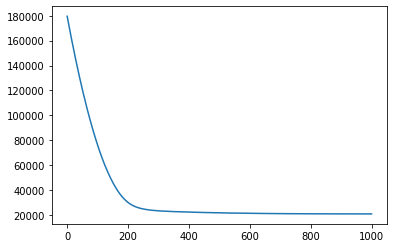

In [21]:
plt.plot(train_hist)

In [22]:
def generate_submission(net, test_x):
    preds = net(test_x).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
    return submission

In [23]:
submission = generate_submission(net, test_X)

In [24]:
submission

,Id,SalePrice
0,1461,113760.000000
1,1462,162330.015625
2,1463,190211.671875
3,1464,214267.468750
4,1465,178998.734375
...,...,...
1454,2915,69771.531250
1455,2916,86096.203125
1456,2917,194097.218750
1457,2918,99958.578125


### 按照教程来一遍

In [30]:
def set_figsize(figsize=(3.5, 2.5)):
    """Change the default figure size"""
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize
    

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    """
    对数 plot: 10^1, 10^-1, 10^-2
    """
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

In [25]:
def log_rmse(net, features, labels):
    """
    kaggle 的衡量标准
    将小于1的值设成1，使得取对数时数值更稳定
    """
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()

In [50]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, 
          weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # 这里使用了Adam优化算法
#     trainer = gTrainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, 'wd': weight_decay})
    if weight_decay > 0:
        train_w = gTrainer(net.collect_params(".*weight"), 
                           'sgd', {'learning_rate': learning_rate, 'wd': weight_decay})
        train_b = gTrainer(net.collect_params(".*bias"), 
                           'sgd', {'learning_rate': learning_rate})
    else:
        trainer = gTrainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            if weight_decay > 0:
                train_w.step(batch_size)
                train_b.step(batch_size)
            else:
                trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### K折验证

In [27]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

In [32]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    """
    选择最佳的参数组合
    :return 平均训练误差, 平均验证误差
    """
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f'
              % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

fold 0, train rmse 0.152373, valid rmse 0.135595
fold 1, train rmse 0.147818, valid rmse 0.637428
fold 2, train rmse 0.145162, valid rmse 0.152840
fold 3, train rmse 0.143111, valid rmse 0.131166
fold 4, train rmse 0.139228, valid rmse 0.162148
5-fold validation: avg train rmse 0.145538, avg valid rmse 0.243835


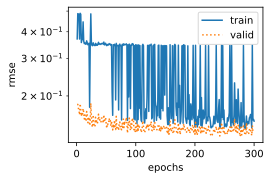

In [98]:
# k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
k, num_epochs, lr, weight_decay, batch_size = 5, 300, 0.036, 0.32, 146
train_l, valid_l = k_fold(k, train_X, train_y, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

fold 0, train rmse 0.151607, valid rmse 0.161323
fold 1, train rmse 0.143262, valid rmse 0.194538
fold 2, train rmse 0.142425, valid rmse 0.164532
fold 3, train rmse 0.148336, valid rmse 0.141667
fold 4, train rmse 0.135900, valid rmse 0.165943
Learning Rate: 0.003, Weight Decay: 0, avg train rmse: 0.14430599808692932, avg valid rmse: 0.16560067236423492
fold 0, train rmse 0.152494, valid rmse 0.160076
fold 1, train rmse 0.143670, valid rmse 0.206163
fold 2, train rmse 0.143351, valid rmse 0.164898
fold 3, train rmse 0.149003, valid rmse 0.141310
fold 4, train rmse 0.137430, valid rmse 0.165964
Learning Rate: 0.003, Weight Decay: 0.01, avg train rmse: 0.14518952369689941, avg valid rmse: 0.16768210232257844
fold 0, train rmse 0.154066, valid rmse 0.159564
fold 1, train rmse 0.144007, valid rmse 0.221600
fold 2, train rmse 0.144746, valid rmse 0.165566
fold 3, train rmse 0.150125, valid rmse 0.141293
fold 4, train rmse 0.139233, valid rmse 0.166010
Learning Rate: 0.003, Weight Decay: 0.

fold 0, train rmse 0.136764, valid rmse 0.157746
fold 1, train rmse 0.131212, valid rmse 0.153400
fold 2, train rmse 0.131451, valid rmse 0.156726
fold 3, train rmse 0.137215, valid rmse 0.138091
fold 4, train rmse 0.123590, valid rmse 0.161000
Learning Rate: 0.008, Weight Decay: 0.01, avg train rmse: 0.13204657137393952, avg valid rmse: 0.15339259803295135
fold 0, train rmse 0.136682, valid rmse 0.155335
fold 1, train rmse 0.131765, valid rmse 0.153994
fold 2, train rmse 0.131653, valid rmse 0.156529
fold 3, train rmse 0.137481, valid rmse 0.137464
fold 4, train rmse 0.124337, valid rmse 0.160901
Learning Rate: 0.008, Weight Decay: 0.02, avg train rmse: 0.13238359242677689, avg valid rmse: 0.15284460484981538
fold 0, train rmse 0.139351, valid rmse 0.153734
fold 1, train rmse 0.133420, valid rmse 0.158146
fold 2, train rmse 0.132864, valid rmse 0.156980
fold 3, train rmse 0.139113, valid rmse 0.137386
fold 4, train rmse 0.126570, valid rmse 0.160933
Learning Rate: 0.008, Weight Decay:

fold 0, train rmse 0.134661, valid rmse 0.159686
fold 1, train rmse 0.128297, valid rmse 0.152939
fold 2, train rmse 0.129421, valid rmse 0.153610
fold 3, train rmse 0.133872, valid rmse 0.136893
fold 4, train rmse 0.121353, valid rmse 0.160009
Learning Rate: 0.016, Weight Decay: 0.02, avg train rmse: 0.12952075600624086, avg valid rmse: 0.1526273012161255
fold 0, train rmse 0.136539, valid rmse 0.153848
fold 1, train rmse 0.130638, valid rmse 0.154941
fold 2, train rmse 0.130824, valid rmse 0.154805
fold 3, train rmse 0.134887, valid rmse 0.134852
fold 4, train rmse 0.123315, valid rmse 0.159696
Learning Rate: 0.016, Weight Decay: 0.04, avg train rmse: 0.13124076277017593, avg valid rmse: 0.15162840187549592
fold 0, train rmse 0.142566, valid rmse 0.151463
fold 1, train rmse 0.134938, valid rmse 0.169828
fold 2, train rmse 0.135191, valid rmse 0.156501
fold 3, train rmse 0.139735, valid rmse 0.135224
fold 4, train rmse 0.129259, valid rmse 0.160546
Learning Rate: 0.016, Weight Decay: 

fold 0, train rmse 0.137683, valid rmse 0.156164
fold 1, train rmse 0.129133, valid rmse 0.153089
fold 2, train rmse 0.129755, valid rmse 0.153374
fold 3, train rmse 0.139217, valid rmse 0.140993
fold 4, train rmse 0.123768, valid rmse 0.159371
Learning Rate: 0.024, Weight Decay: 0.04, avg train rmse: 0.1319113478064537, avg valid rmse: 0.15259836614131927
fold 0, train rmse 0.145279, valid rmse 0.153164
fold 1, train rmse 0.133569, valid rmse 0.164911
fold 2, train rmse 0.135318, valid rmse 0.155879
fold 3, train rmse 0.137794, valid rmse 0.133992
fold 4, train rmse 0.125674, valid rmse 0.158232
Learning Rate: 0.024, Weight Decay: 0.08, avg train rmse: 0.13552672863006593, avg valid rmse: 0.15323559641838075
fold 0, train rmse 0.153028, valid rmse 0.144942
fold 1, train rmse 0.137877, valid rmse 0.210872
fold 2, train rmse 0.139983, valid rmse 0.154226
fold 3, train rmse 0.152179, valid rmse 0.139661
fold 4, train rmse 0.137424, valid rmse 0.161685
Learning Rate: 0.024, Weight Decay: 

fold 0, train rmse 0.145424, valid rmse 0.148562
fold 1, train rmse 0.131493, valid rmse 0.157198
fold 2, train rmse 0.135138, valid rmse 0.155507
fold 3, train rmse 0.135326, valid rmse 0.130751
fold 4, train rmse 0.130153, valid rmse 0.161237
Learning Rate: 0.032, Weight Decay: 0.08, avg train rmse: 0.13550688922405243, avg valid rmse: 0.150650817155838
fold 0, train rmse 0.190625, valid rmse 0.150364
fold 1, train rmse 0.136246, valid rmse 0.185571
fold 2, train rmse 0.144552, valid rmse 0.157918
fold 3, train rmse 0.147803, valid rmse 0.139005
fold 4, train rmse 0.137403, valid rmse 0.163630
Learning Rate: 0.032, Weight Decay: 0.16, avg train rmse: 0.15132581293582917, avg valid rmse: 0.15929750204086304
fold 0, train rmse 0.168676, valid rmse 0.140175
fold 1, train rmse 0.137925, valid rmse 0.184155
fold 2, train rmse 0.141013, valid rmse 0.150427
fold 3, train rmse 0.155627, valid rmse 0.138488
fold 4, train rmse 0.141686, valid rmse 0.162768
Learning Rate: 0.032, Weight Decay: 0

fold 0, train rmse 0.224803, valid rmse 0.157715
fold 1, train rmse 0.136887, valid rmse 0.165491
fold 2, train rmse 0.137673, valid rmse 0.152375
fold 3, train rmse 0.145273, valid rmse 0.137356
fold 4, train rmse 0.155033, valid rmse 0.167999
Learning Rate: 0.04, Weight Decay: 0.16, avg train rmse: 0.1599338948726654, avg valid rmse: 0.1561873286962509
fold 0, train rmse 0.141574, valid rmse 0.131910
fold 1, train rmse 0.142163, valid rmse 0.200015
fold 2, train rmse 0.139821, valid rmse 0.150100
fold 3, train rmse 0.166300, valid rmse 0.146893
fold 4, train rmse 0.139057, valid rmse 0.165646
Learning Rate: 0.04, Weight Decay: 0.32, avg train rmse: 0.14578332602977753, avg valid rmse: 0.15891267657279967
fold 0, train rmse 0.146101, valid rmse 0.133487
fold 1, train rmse 0.141833, valid rmse 0.162877
fold 2, train rmse 0.146852, valid rmse 0.153360
fold 3, train rmse 0.149907, valid rmse 0.136980
fold 4, train rmse 0.140955, valid rmse 0.165155
Learning Rate: 0.04, Weight Decay: 0.64

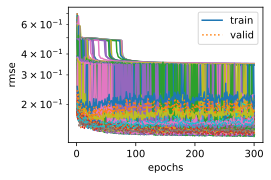

In [66]:
# 网格调参: 取最小平均k-fold误差
# epochs: 50, 100, 200, 400, 800, 1600
# lr: 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 不能大于0.1
# batch_size: 50, 100, 200, 400
# weight decay: 0, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 不能大于10
lr_tunning = [0.003, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024, 0.028, 0.032, 0.036, 0.04]  # 0.003 ~ 0.1, step: 0.004
wd_tunning = [0, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12]  # 0 ~ 10
train_results = nd.zeros((len(lr_tunning), len(wd_tunning)))
valid_results = nd.zeros((len(lr_tunning), len(wd_tunning)))
for i, try_lr in enumerate(lr_tunning):
    for j, try_wd in enumerate(wd_tunning):
        train_l, valid_l = k_fold(k, train_X, train_y, num_epochs, try_lr, try_wd, batch_size)
        train_results[i][j] = train_l
        valid_results[i][j] = valid_l
        print('Learning Rate: {}, Weight Decay: {}, avg train rmse: {}, avg valid rmse: {}'.format(
            try_lr, try_wd, train_l, valid_l))
# 预处理步骤调整:
# 网络模型调整: 使用隐藏层, 使用dropout, 使用惩罚项

In [89]:
valid_results < 0.15


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
<NDArray 11x11 @cpu(0)>

In [93]:
print(valid_results[8][3], valid_results[-1][4], valid_results[-2][6])
print(lr_tunning[8], wd_tunning[3])
print(lr_tunning[-1], wd_tunning[4])
print(lr_tunning[-2], wd_tunning[6])


[0.14978023]
<NDArray 1 @cpu(0)> 
[0.14674124]
<NDArray 1 @cpu(0)> 
[0.14977732]
<NDArray 1 @cpu(0)>
0.032 0.04
0.04 0.08
0.036 0.32


In [72]:
train_results


[[0.144306   0.14518952 0.14643534 0.14918685 0.16117239 0.30479217
  0.30848536 0.31093818 0.30944282 0.16340463 0.19036086]
 [0.13872999 0.13926433 0.1400689  0.14192918 0.14812332 0.27557084
  0.30733505 0.3090111  0.27725223 0.16170853 0.19441737]
 [0.13197416 0.13204657 0.13238358 0.13426377 0.13920008 0.159589
  0.30381966 0.30465284 0.15401648 0.16518877 0.20463209]
 [0.13010341 0.1299972  0.13059379 0.13222042 0.13711838 0.15501857
  0.30247724 0.23565963 0.15023735 0.16860087 0.20983604]
 [0.12921876 0.12870184 0.12952076 0.13124076 0.13633771 0.14917202
  0.2105531  0.15395512 0.15030512 0.16954961 0.20971923]
 [0.1280843  0.12842575 0.12901856 0.13078244 0.13579537 0.14560324
  0.196623   0.14684883 0.14998935 0.17059787 0.20944726]
 [0.12745012 0.1277121  0.12873055 0.13191135 0.13552673 0.14409812
  0.1905898  0.1467569  0.15106364 0.17036623 0.209622  ]
 [0.12733227 0.12785907 0.1276341  0.13001502 0.13577165 0.14354834
  0.1912375  0.14657246 0.15365036 0.17319612 0.211

In [86]:
def train_and_pred(lr, wd):
    net = get_net()
    train_ls, _ = train(net, train_X, train_y, None, None, num_epochs, lr, weight_decay, batch_size)
    print("Trainning history: ", train_ls)
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    generate_submission(net, test_X)

Trainning history:  [0.44667596, 0.44385964, 0.4427492, 0.43553916, 0.32663614, 0.4403865, 0.36505714, 0.3310465, 0.32627723, 0.31881088, 0.32529, 0.31753746, 0.32757017, 0.32406166, 0.31934226, 0.31948507, 0.31690305, 0.32430154, 0.31638554, 0.3295736, 0.3200459, 0.31813484, 0.31575924, 0.31700492, 0.3209088, 0.31665012, 0.31706625, 0.3159224, 0.31249255, 0.3181353, 0.3141633, 0.3153522, 0.31418595, 0.31436196, 0.31605312, 0.3150562, 0.3138777, 0.31784198, 0.31660846, 0.32259881, 0.3129193, 0.31821078, 0.31699622, 0.3179656, 0.31410468, 0.31865627, 0.31523153, 0.32135427, 0.31392613, 0.31552857, 0.19781625, 0.31295174, 0.31478953, 0.31452933, 0.31875724, 0.3179629, 0.3144758, 0.31507298, 0.31329814, 0.31756932, 0.3162446, 0.31860203, 0.31426612, 0.31455818, 0.32061204, 0.3117733, 0.31660894, 0.3138311, 0.3135232, 0.3115149, 0.31609398, 0.3169781, 0.17534304, 0.17479353, 0.31214577, 0.31746995, 0.3134375, 0.16971356, 0.3139522, 0.3132422, 0.18735649, 0.3145047, 0.31185433, 0.31557232, 

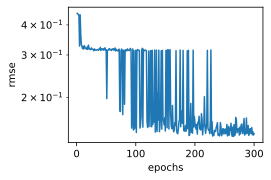

In [108]:
# 0.032, 0.04
# 0.04, 0.08
# 0.036, 0.32  波动最大
train_and_pred(0.032, 0.03)

Trainning history:  [0.3466931, 0.46343103, 0.439819, 0.44578034, 0.43665662, 0.34081608, 0.3418027, 0.32894346, 0.32771698, 0.32515272, 0.3208616, 0.32761195, 0.32651466, 0.3169594, 0.31769526, 0.32000133, 0.32391688, 0.32119215, 0.31738082, 0.32276967, 0.31367654, 0.31439945, 0.32509205, 0.313145, 0.32802936, 0.31829315, 0.32236484, 0.31574377, 0.31856096, 0.3182023, 0.3169315, 0.31822503, 0.32532832, 0.31537384, 0.31572294, 0.31564954, 0.3167688, 0.15896772, 0.314915, 0.31633347, 0.31698146, 0.3131241, 0.31661913, 0.31595063, 0.31478095, 0.3201043, 0.3157941, 0.31492358, 0.31856877, 0.31652856, 0.31647244, 0.31355447, 0.31784326, 0.31169713, 0.31737193, 0.15768415, 0.31773913, 0.31328315, 0.31561095, 0.15987681, 0.31460968, 0.3153081, 0.31216863, 0.31587112, 0.15237503, 0.31671208, 0.31678674, 0.31334046, 0.31280598, 0.3139475, 0.14947508, 0.31707224, 0.16064715, 0.3125819, 0.31484348, 0.31277034, 0.31664556, 0.31742346, 0.31303078, 0.15271018, 0.31325495, 0.16278686, 0.16498567, 0.

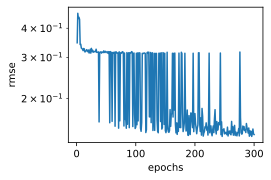

In [107]:
train_and_pred(0.032, 0.02)

Trainning history:  [0.4501549, 0.44607762, 0.4376565, 0.43843734, 0.43810478, 0.31997436, 0.33468172, 0.33237988, 0.32936653, 0.31970727, 0.32421142, 0.3191536, 0.31533864, 0.3248168, 0.32243758, 0.3263246, 0.32077688, 0.32502565, 0.31698576, 0.3216079, 0.3266753, 0.3161205, 0.31772605, 0.31822097, 0.3146987, 0.3222903, 0.3129969, 0.31564766, 0.31710497, 0.3159416, 0.31803516, 0.16809496, 0.31681702, 0.31801552, 0.31408593, 0.31624496, 0.31220543, 0.21522197, 0.3188365, 0.31534716, 0.15620223, 0.31588593, 0.31426722, 0.31361482, 0.31930155, 0.173939, 0.31315815, 0.31833354, 0.31505045, 0.31537455, 0.31764036, 0.19774736, 0.3163595, 0.31432205, 0.17024788, 0.32034442, 0.31609103, 0.17718862, 0.31995404, 0.3140656, 0.31427157, 0.18421192, 0.31495818, 0.3189942, 0.31280228, 0.18819222, 0.31350264, 0.31425306, 0.31835672, 0.18999876, 0.31527874, 0.14728403, 0.3132045, 0.313573, 0.31554696, 0.31486034, 0.31363672, 0.31220508, 0.31803262, 0.31303787, 0.31472522, 0.31551436, 0.31340805, 0.31

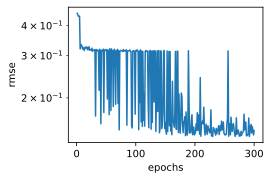

In [106]:
train_and_pred(0.032, 0.04)

### 坑
1. 参数全是nan:
    - 原因: 梯度爆炸
    - 解决: 简化 输入层, 删掉隐藏层
2. Adam 收敛不了: 性能更差了, 应该是 过拟合了
    - 增大 迭代次数
    - 增大 learning rate
3. 如何突破 0.12 的关卡:
    - 目前只要能低于0.15. 就能 在3000名内了
4. 为什么 用网格搜索得到0.14的结果, 会造成0.16的误差
    - 不稳定, 波动大
    - 意外取到一个0.12 把误差的均值拉低了
    - 这个0.12怎么取到的
    - 在(0.032, 0.04)附近微调, 终于取到 0.14891, 排在2957
5. 0.14891 是我目前的极限了(2019-10-24记)
6. SGD:
    - pros: 可在线学习, 收敛快
    - cons: 梯度更新太快，而且会产生梯度震荡，使收敛不稳定

In [109]:
gTrainer?